# Implementing a Neural Network from Scratch
## Author: Gary Corcoran
## Date: Dec. 8th, 2017

### Reference
http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

## Generating a dataset

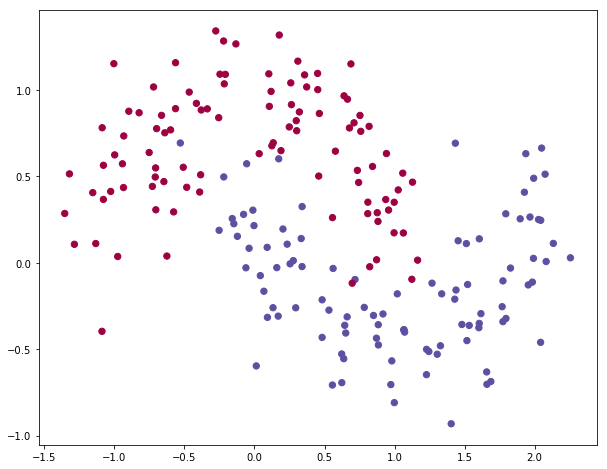

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_moons
import matplotlib

# display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# generate a dataset and plot it
np.random.seed(0)
X, y = make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

## Logistic Regression

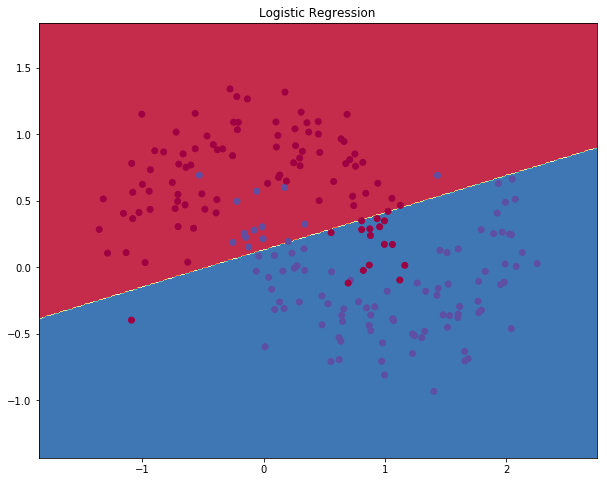

In [24]:
from sklearn.linear_model import LogisticRegressionCV

def plot_decision_boundary(pred_func):
    # set min and max values and give it some padding
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    h = 0.01
    # generate grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
# train the logistic regression classifier
clf = LogisticRegressionCV()
clf.fit(X, y)
# plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title('Logistic Regression')

## Training a Neural Network

Loss after iteraion 0: 0.4186272131546619
Loss after iteraion 1000: 0.04652040552535531
Loss after iteraion 2000: 0.04334012847348133
Loss after iteraion 3000: 0.04130343563231914
Loss after iteraion 4000: 0.0399001571075337
Loss after iteraion 5000: 0.03897114641753751
Loss after iteraion 6000: 0.03837284543071122
Loss after iteraion 7000: 0.03798858994365198
Loss after iteraion 8000: 0.037738957333830946
Loss after iteraion 9000: 0.037573957118804346
Loss after iteraion 10000: 0.037462849753539175
Loss after iteraion 11000: 0.03738668745343699
Loss after iteraion 12000: 0.037333627392173926
Loss after iteraion 13000: 0.03729612912531224
Loss after iteraion 14000: 0.03726929576412012
Loss after iteraion 15000: 0.037249885237223744
Loss after iteraion 16000: 0.03723571208959248
Loss after iteraion 17000: 0.0372252788262478
Loss after iteraion 18000: 0.03721754421818203
Loss after iteraion 19000: 0.037211774821775595


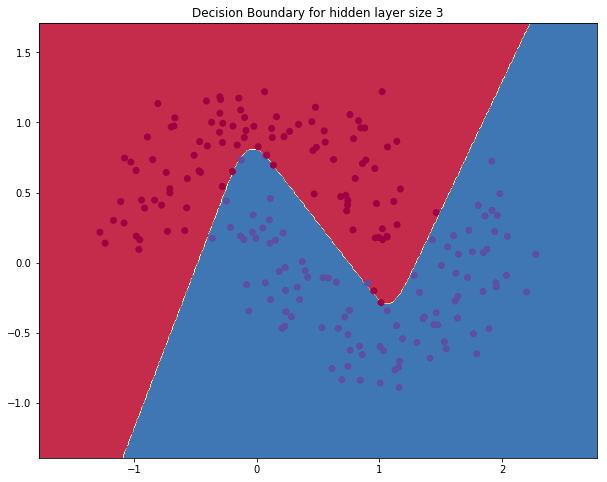

In [32]:
# neural network parameters
num_examples = len(X)
nn_input_dim = 2
nn_output_dim = 2
epsilon = 0.01  # learning rate
reg_lambda = 0.01  # regularization strength


def calculate_loss(model):
    """
    Calculate training loss over all examples.
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # forward propagation to calculate predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # calculate the loss
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # add regularization term to loss
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    return 1./num_examples * data_loss

def predict(model, x):
    """
    Predict output for x using model.
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # forward propagation to calculate predictions
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    """
    Learns parameters for the neural network and returns the model.
    
    @param nn_hdim: number of nodes in the hidden layer
    @param num_passes: number of passes through the training data for gradient
                        descent
    @param print_loss: if true, print the loss every 1000 iterations
    """
    # initialize the parameters the random values
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    # this is what we return at the end
    model = {}
    
    # gradient descent for each batch
    for i in range(0, num_passes):
        
        # forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1,2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # add regularization terms
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # optionally print the loss
        if print_loss and i % 1000 == 0:
            print('Loss after iteraion {0}: {1}'.format(i, calculate_loss(model)))
    
    return model

# build a model with 3-dimensional hidden layer
model = build_model(3, print_loss=True)
# plot decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title('Decision Boundary for hidden layer size 3')

## Varying the hidden layer size

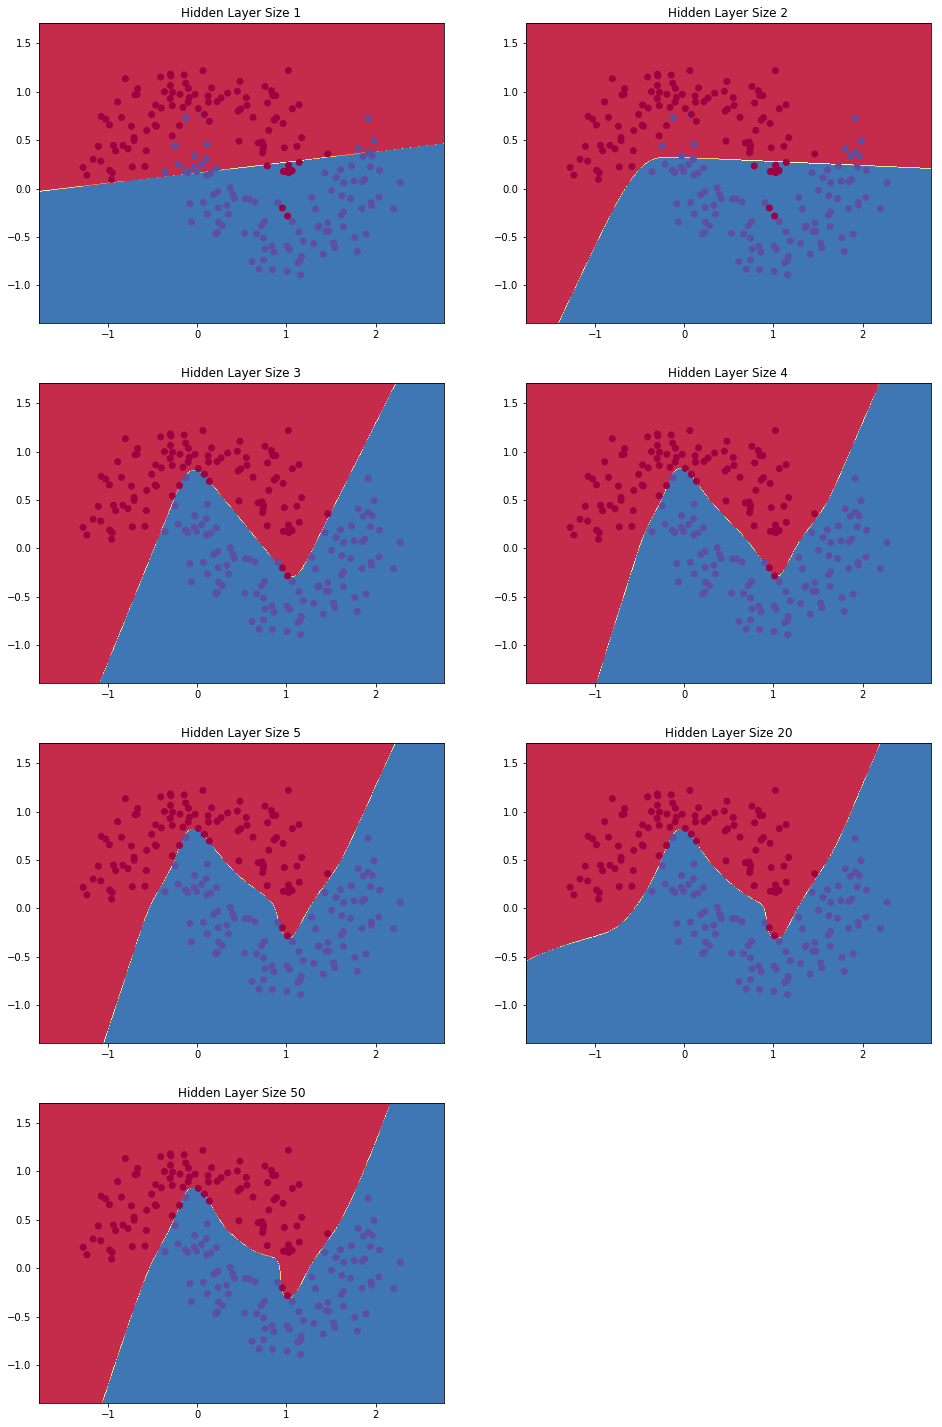

In [33]:
plt.figure(figsize=(16,32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5,2, i+1)
    plt.title('Hidden Layer Size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))